Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import io
import seaborn as sns
#from ydata_profiling import ProfileReport

Uploading the dataset and converting csv file to dataframe

In [3]:
from google.colab import files
uploaded = files.upload()

Saving diabetes.csv to diabetes.csv


Storing Dataset in a Pandas Dataframe

In [4]:
dataf = pd.read_csv(io.BytesIO(uploaded['diabetes.csv']))

Identifying Correlations on columns

<Axes: >

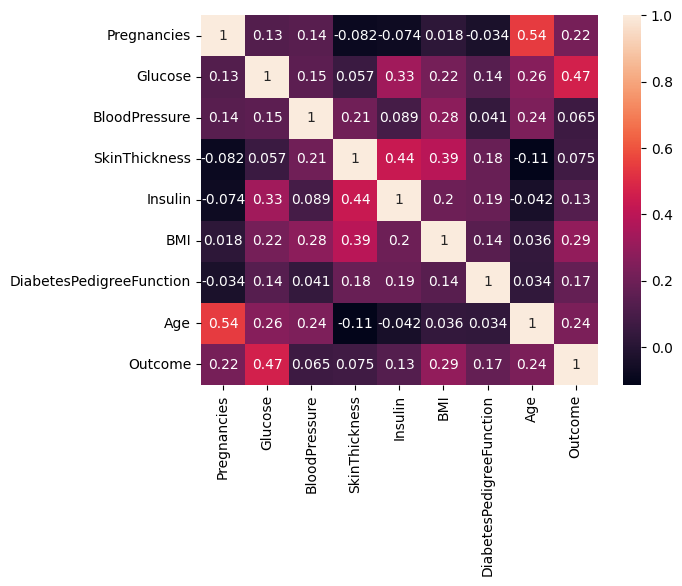

In [5]:
# print(dataf.corr())
sns.heatmap(dataf.corr(),annot=True)

In [6]:
dfcopy = dataf.copy(deep = True)
dfcopy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = dfcopy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
dfcopy.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [7]:
dfcopy['Glucose'].fillna(dfcopy['Glucose'].mean(), inplace = True)
dfcopy['BloodPressure'].fillna(dfcopy['BloodPressure'].mean(), inplace = True)
dfcopy['SkinThickness'].fillna(dfcopy['SkinThickness'].median(), inplace = True)
dfcopy['Insulin'].fillna(dfcopy['Insulin'].median(), inplace = True)
dfcopy['BMI'].fillna(dfcopy['BMI'].median(), inplace = True)

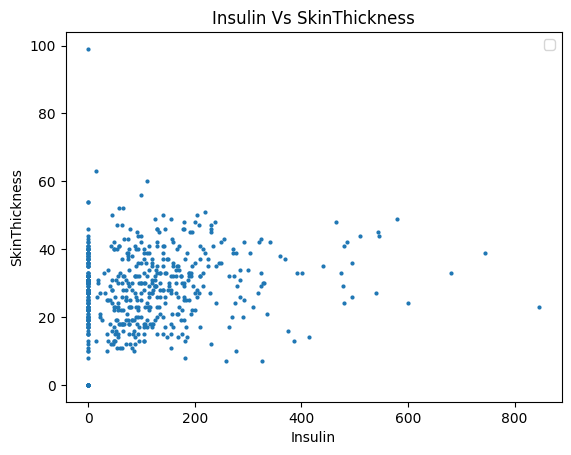

In [8]:
xCol = dataf['Insulin']
yCol = dataf['SkinThickness']
plt.scatter(xCol,yCol,s=4)
plt.xlabel('Insulin')
plt.ylabel('SkinThickness')
plt.title('Insulin Vs SkinThickness')
plt.legend()
plt.show()

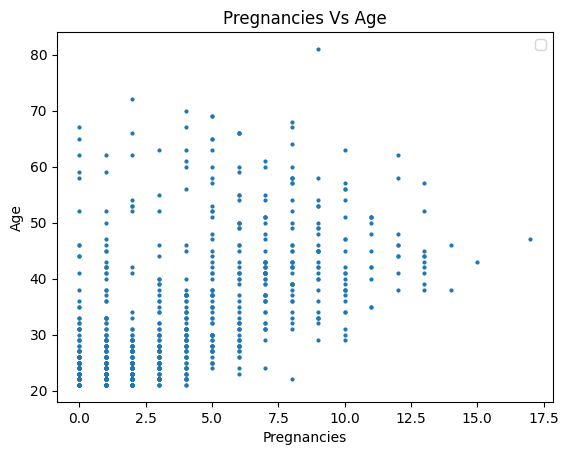

In [9]:
xCol = dataf['Pregnancies']
yCol = dataf['Age']
plt.scatter(xCol,yCol,s=4)
plt.xlabel('Pregnancies')
plt.ylabel('Age')
plt.title('Pregnancies Vs Age')
plt.legend()
plt.show()

Scaling the dataframe so we can implement model on it

In [10]:
# dataf.describe()
# dataf.isnull().sum()
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
scaleddf = pd.DataFrame(sc_X.fit_transform(dfcopy.drop(["Outcome"], axis =1),),columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'])

In [11]:
scaleddf.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865108,-0.033518,0.670643,-0.181541,0.166619,0.468492,1.425995
1,-0.844885,-1.206162,-0.529859,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672
2,1.233880,2.015813,-0.695306,-0.012301,-0.181541,-1.332500,0.604397,-0.105584
3,-0.844885,-1.074652,-0.529859,-0.695245,-0.540642,-0.633881,-0.920763,-1.041549
4,-1.141852,0.503458,-2.680669,0.670643,0.316566,1.549303,5.484909,-0.020496


In [12]:
file=ProfileReport(dataf)
file.to_file(output_file='pimaprofile.html')

Implementing KNN Model

In [13]:
y = dfcopy.Outcome

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaleddf, y, test_size = 1/3, random_state = 42, stratify=y)

In [18]:
from sklearn.neighbors import KNeighborsClassifier
# K=11 we have found k = 11 as best fit, so we are using k as 11
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(11)

knn.fit(X_train,y_train)
print("Knn score - ", knn.score(X_test,y_test))

knn score -  0.765625


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


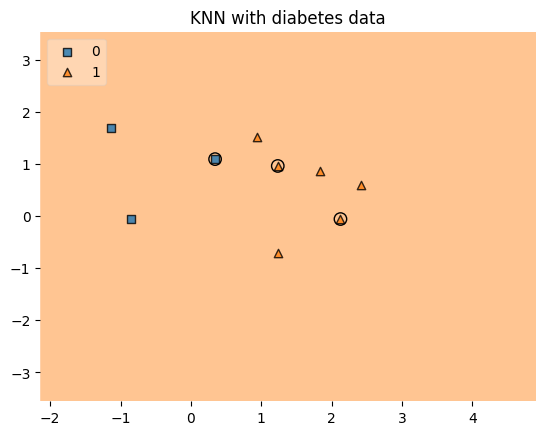

In [19]:
from mlxtend.plotting import plot_decision_regions
value = 20000
width  =20000

plot_decision_regions(scaleddf.values, y.values, clf = knn, legend =2,filler_feature_values={2: value, 3: value, 4: value, 5: value, 6: value, 7: value},
                      filler_feature_ranges={2: width, 3: width, 4: width, 5: width, 6: width, 7: width},
                      X_highlight=X_test.values)
plt.title("KNN with diabetes data")
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
y_pred = knn.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 23.52222222222222, 'Predicted label')

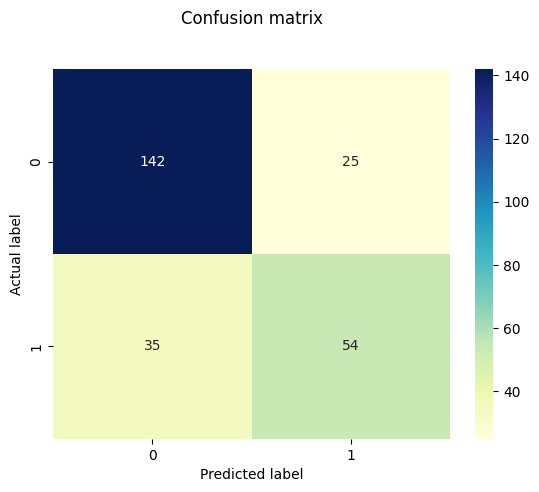

In [21]:
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [22]:
def model_evaluation(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta = 2.0)

    results = pd.DataFrame([[model_name, acc, prec, rec, f1, f2]],
                       columns = ["Model", "Accuracy", "Precision", "Recall",
                                 "F1 SCore", "F2 Score"])
    results = results.sort_values(["Precision", "Recall", "F2 Score"], ascending = False)
    return results

model_evaluation(y_test, y_pred, "KNN")

,Model,Accuracy,Precision,Recall,F1 SCore,F2 Score
0,KNN,0.765625,0.683544,0.606742,0.642857,0.62069


Auc ROC Score

In [23]:
from sklearn.metrics import auc, roc_auc_score, roc_curve

y_pred_proba = knn.predict_proba(X_test)[:,-1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)

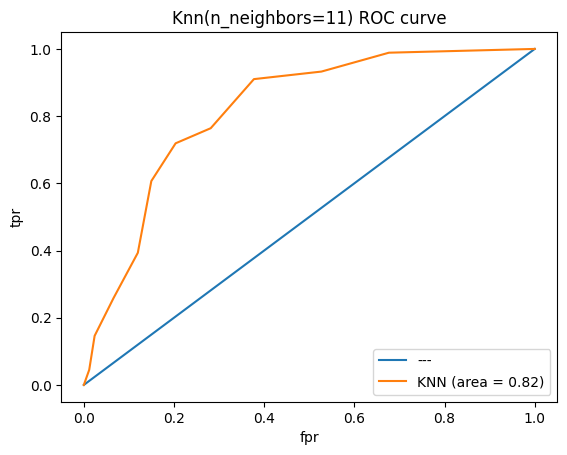

In [24]:
classifier_roc_auc = roc_auc_score(y_test, y_pred_proba)
plt.plot([0,1],[0,1], label = "---")
plt.plot(fpr, tpr, label ='KNN (area = %0.2f)' % classifier_roc_auc)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('Knn(n_neighbors=11) ROC curve')
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

In [25]:
#Hyper parameters tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV
parameters_grid = {"n_neighbors": np.arange(0,50)}
knn= KNeighborsClassifier()
knn_GSV = GridSearchCV(knn, param_grid=parameters_grid, cv = 5)
knn_GSV.fit(scaleddf, y)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 213, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklea

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [26]:
print("Best Params For Knn " ,knn_GSV.best_params_)
print("Best score For Knn " ,knn_GSV.best_score_)

Best Params For Knn  {'n_neighbors': 25}
Best score For Knn  0.7721840251252015


Naive Bayes

In [27]:
from sklearn.naive_bayes import GaussianNB
nbmodel = GaussianNB()
nbmodel.fit(X_train, y_train)
y_pred = nbmodel.predict(X_test)

In [28]:
from sklearn import metrics

In [29]:
print("Accuracy of Naive Bayes is ", metrics.accuracy_score(y_test, y_pred))

Accuracy of Naive Bayes is  0.72265625


In [30]:
nbmodel_score = nbmodel.score(X_test, y_test)
print('Model score :',nbmodel_score)
print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, y_pred))
print('Accuracy :',metrics.accuracy_score(y_test,y_pred))
print('Precision :',metrics.precision_score(y_test,y_pred))
print('Recall :',metrics.recall_score(y_test,y_pred))
print('F-score :',metrics.f1_score(y_test,y_pred))

Model score : 0.72265625
Confusion Matrix:
 [[131  36]
 [ 35  54]]
Accuracy : 0.72265625
Precision : 0.6
Recall : 0.6067415730337079
F-score : 0.6033519553072626


Decision tree

In [37]:
decisiontree_x = dataf.drop('Outcome', axis=1)
decisiontree_y = dataf[['Outcome']]

# Train Test Split
from sklearn.model_selection import train_test_split
X_train_decisiontree, X_test_decisiontree, y_train_decisiontree, y_test_decisiontree = train_test_split(decisiontree_x, decisiontree_y, test_size=0.20, random_state=0)

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=10).fit(X_train_decisiontree, y_train_decisiontree)
y_pred_decisiontree = rf_clf.predict(X_test_decisiontree)


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test_decisiontree, y_pred_decisiontree))
print(accuracy_score(y_test_decisiontree, y_pred_decisiontree))
print(classification_report(y_test_decisiontree, y_pred_decisiontree))

<ipython-input-37-eb033c4d76b7>:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf = RandomForestClassifier(n_estimators=10).fit(X_train_decisiontree, y_train_decisiontree)


[[90 17]
 [19 28]]
0.7662337662337663
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       107
           1       0.62      0.60      0.61        47

    accuracy                           0.77       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.76      0.77      0.76       154

